# Orbit Computation

This tutorial demonstrates how to generate satellite orbits using various models.

## Setup

In [1]:
import sys

! {sys.executable} -m pip install --quiet LibraryCorePy
! {sys.executable} -m pip install --quiet LibraryMathematicsPy
! {sys.executable} -m pip install --quiet LibraryPhysicsPy
! {sys.executable} -m pip install --quiet LibraryAstrodynamicsPy

In [1]:
import numpy as np
import pandas as pd

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [2]:
import Library.Core as Core
import Library.Mathematics as Mathematics
import Library.Physics as Physics
import Library.Astrodynamics as Astrodynamics

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

to-Python converter for library::physics::time::DateTime already registered; second conversion method ignored.

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

to-Python converter for library::math::obj::IntervalBase::Type already registered; second conversion method ignored.



In [3]:
Length = Physics.Units.Length
Angle = Physics.Units.Angle
Time = Physics.Time
LLA = Physics.Coordinate.Spherical.LLA
Frame = Physics.Coordinate.Frame
Environment = Physics.Environment
Earth = Physics.Environment.Objects.CelestialBodies.Earth

Trajectory = Astrodynamics.Trajectory
Orbit = Trajectory.Orbit

---

## SGP4

### Computation

In [4]:
environment = Environment.Default()

Create a Classical Orbital Element (COE) set:

In [5]:
a = Length.Kilometers(7000.0)
e = 0.0001
i = Angle.Degrees(35.0)
raan = Angle.Degrees(40.0)
aop = Angle.Degrees(45.0)
nu = Angle.Degrees(50.0)

coe = Orbit.Models.Kepler.COE(a, e, i, raan, aop, nu)

Setup a Keplerian orbital model:

In [6]:
epoch = Time.Instant.DateTime(Time.DateTime(2018, 1, 1, 0, 0, 0), Time.Scale.UTC)
earth = environment.accessCelestialObjectWithName("Earth")

keplerian_model = Orbit.Models.Kepler(coe, epoch, earth, Orbit.Models.Kepler.PerturbationType.No)

Create a Two-Line Element (TLE) set:

In [7]:
tle = Orbit.Models.SGP4.TLE("1 25544U 98067A   18231.17878740  .00000187  00000-0  10196-4 0  9994",
                            "2 25544  51.6447  64.7824 0005971  73.1467  36.4366 15.53848234128316")

Setup a SGP4 orbital model:

In [8]:
sgp4_model = Orbit.Models.SGP4(tle)

Setup the orbit:

In [9]:
# orbit = Orbit(keplerian_model, environment.accessCelestialObjectWithName("Earth"))
orbit = Orbit(sgp4_model, environment.accessCelestialObjectWithName("Earth"))

Now that the orbit is set, we can compute the satellite position:

In [10]:
start_instant = Time.Instant.DateTime(Time.DateTime(2018, 1, 1, 0, 0, 0), Time.Scale.UTC)
end_instant = Time.Instant.DateTime(Time.DateTime(2018, 1, 2, 0, 0, 0), Time.Scale.UTC)

In [11]:
interval = Time.Interval.Closed(start_instant, end_instant)

In [12]:
step = Time.Duration.Minutes(1.0)

Generate a time grid:

In [13]:
instants = interval.generateGrid(step)

In [14]:
states = [[instant, orbit.getStateAt(instant)] for instant in instants]

In [15]:
def convert_state (instant, state):
    
    lla = LLA.Cartesian(state.getPosition().inFrame(Frame.ITRF(), state.getInstant()).getCoordinates(), Earth.EquatorialRadius, Earth.Flattening)
    
    return [
                repr(instant),
                float(instant.getModifiedJulianDate(Time.Scale.UTC)),
                *state.getPosition().getCoordinates().transpose()[0].tolist(),
                *state.getVelocity().getCoordinates().transpose()[0].tolist(),
                float(lla.getLatitude().inDegrees()),
                float(lla.getLongitude().inDegrees()),
                float(lla.getAltitude().inMeters())
            ]

In [16]:
orbit_data = [convert_state(instant, state) for [instant, state] in states]

In [17]:
orbit_df = pd.DataFrame(orbit_data, columns=['$Time^{UTC}$', '$MJD^{UTC}$', '$x_{x}^{ECI}$', '$x_{y}^{ECI}$', '$x_{z}^{ECI}$', '$v_{x}^{ECI}$', '$v_{y}^{ECI}$', '$v_{z}^{ECI}$', '$Latitude$', '$Longitude$', '$Altitude$'])

In [18]:
orbit_df.head()

,$Time^{UTC}$,$MJD^{UTC}$,$x_{x}^{ECI}$,$x_{y}^{ECI}$,$x_{z}^{ECI}$,$v_{x}^{ECI}$,$v_{y}^{ECI}$,$v_{z}^{ECI}$,$Latitude$,$Longitude$,$Altitude$
0,2018-01-01 00:00:00 [UTC],58119.000000,5.092028e+06,-4.257877e+05,-4.466822e+06,-2299.791888,6893.814132,-3274.939990,-41.239157,-105.144169,418053.831368
1,2018-01-01 00:01:00 [UTC],58119.000694,4.940622e+06,-3.379729e+04,-4.652906e+06,-2711.598317,6900.353091,-2925.536649,-43.362869,-101.013630,418686.180613
2,2018-01-01 00:02:00 [UTC],58119.001389,4.766590e+06,3.583480e+05,-4.817620e+06,-3110.916523,6875.289329,-2562.761919,-45.306464,-96.581249,419250.802908
3,2018-01-01 00:03:00 [UTC],58119.002083,4.570731e+06,7.488524e+05,-4.960210e+06,-3495.931670,6818.747897,-2188.277197,-47.044642,-91.836558,419736.720713
4,2018-01-01 00:04:00 [UTC],58119.002778,4.353947e+06,1.135928e+06,-5.080025e+06,-3864.895317,6730.995405,-1803.794709,-48.550854,-86.780520,420134.214136


### Output

In **Earth Fixed** frame:

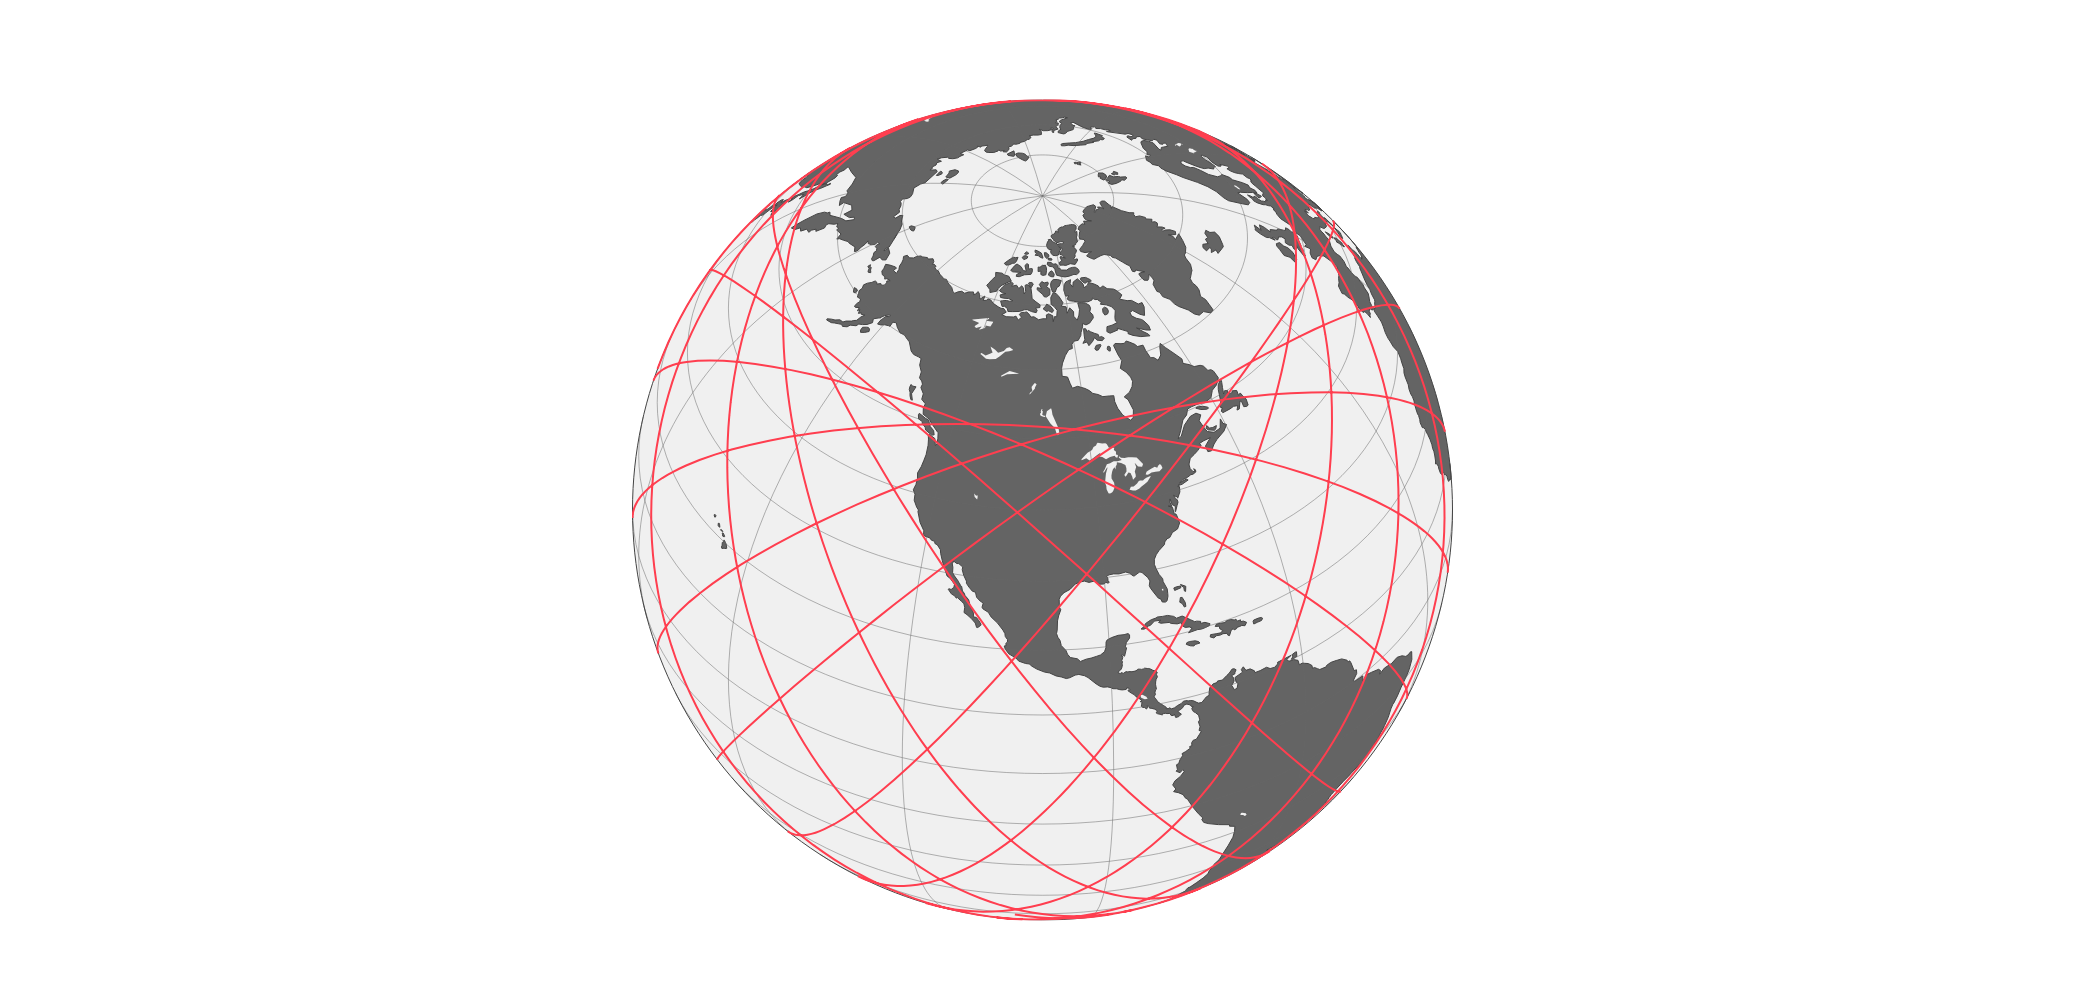

In [19]:
contours = []

contours.append( dict(
    type = 'scattergeo',
    lon = orbit_df['$Longitude$'],
    lat = orbit_df['$Latitude$'],
    mode = 'lines',
    line = dict(
        width = 2,
        color = 'rgb(255, 62, 79)'
    )
) )

layout = dict(
        title = None,
        showlegend = False,
        height=1000,
        geo = dict(
            showland = True,
            showlakes = True,
            showcountries = False,
            showocean = True,
            countrywidth = 0.0,
            landcolor = 'rgb(100, 100, 100)',
            lakecolor = 'rgb(240, 240, 240)',
            oceancolor = 'rgb(240, 240, 240)',
            projection = dict( 
                type = 'orthographic',
                rotation = dict(
                    lon = -100,
                    lat = 40,
                    roll = 0
                )            
            ),
            lonaxis = dict( 
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)',
                gridwidth = 0.5
            ),
            lataxis = dict( 
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)',
                gridwidth = 0.5
            )
        )
    )
    
fig = dict(data=contours, layout=layout)

iplot(fig)

In **Earth Inertial** frame:

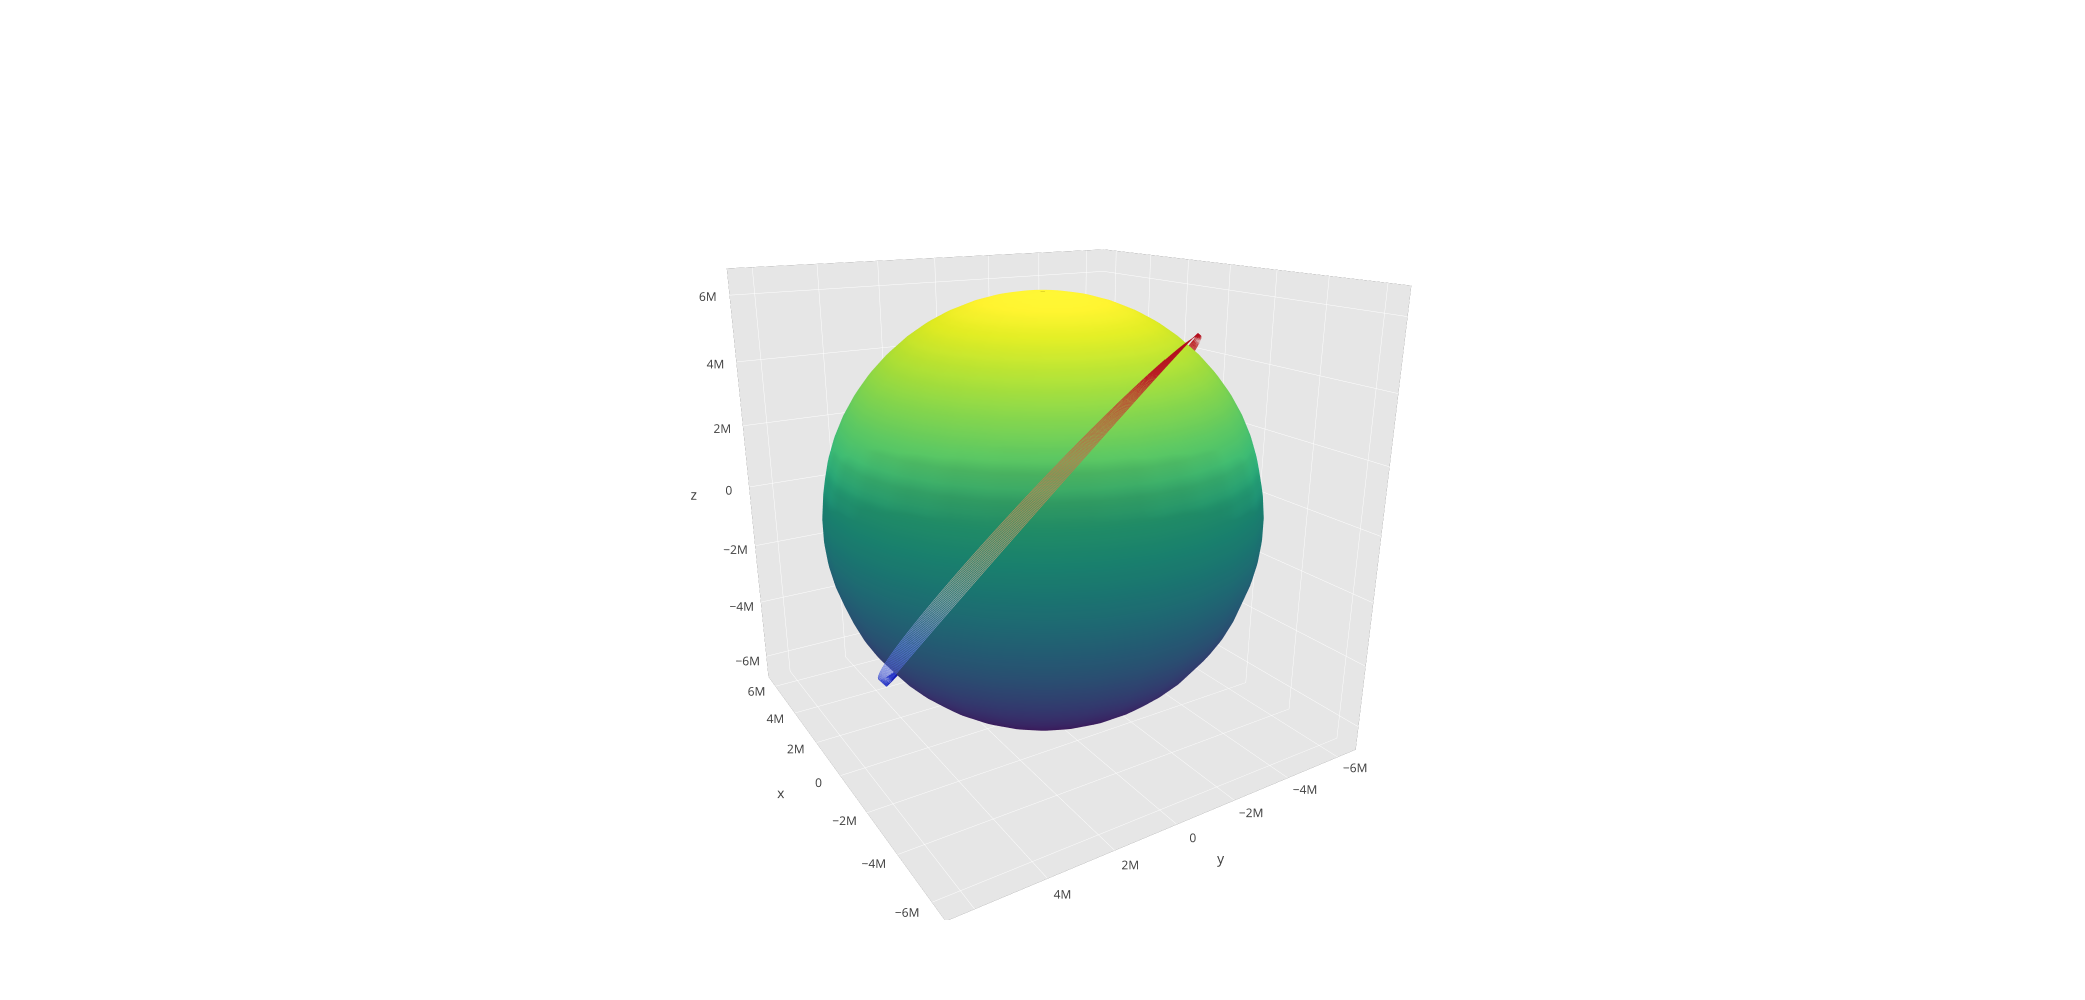

In [20]:
theta = np.linspace(0, 2 * np.pi, 30)
phi = np.linspace(0, np.pi, 30)

theta_grid, phi_grid = np.meshgrid(theta, phi)

r = float(Physics.Environment.Objects.CelestialBodies.Earth.EquatorialRadius.inMeters())

x = r * np.cos(theta_grid) * np.sin(phi_grid)
y = r * np.sin(theta_grid) * np.sin(phi_grid)
z = r * np.cos(phi_grid)

earth = go.Surface(
    x=x,
    y=y,
    z=z,
    colorscale='Viridis',
    showscale=False
)

trace = go.Scatter3d(
    x=orbit_df['$x_{x}^{ECI}$'],
    y=orbit_df['$x_{y}^{ECI}$'],
    z=orbit_df['$x_{z}^{ECI}$'],
    mode='lines',
    marker=dict(
        size=0,
        color=orbit_df['$x_{z}^{ECI}$'],
        colorscale='Viridis',
        showscale=False
    ),
    line=dict(
        color=orbit_df['$x_{z}^{ECI}$'],
        width=1
    )
)

data = [earth, trace]

layout = go.Layout(
    title=None,
#     width=800,
    height=1000,
#     autosize=False,
    showlegend=False,
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=-1.7428,
                y=1.0707,
                z=0.7100,
            )
        ),
        aspectratio = dict( x=1, y=1, z=1 ),
        aspectmode = 'manual'
    ),
)

fig = dict(data=data, layout=layout)

iplot(fig)

Scatter plot:

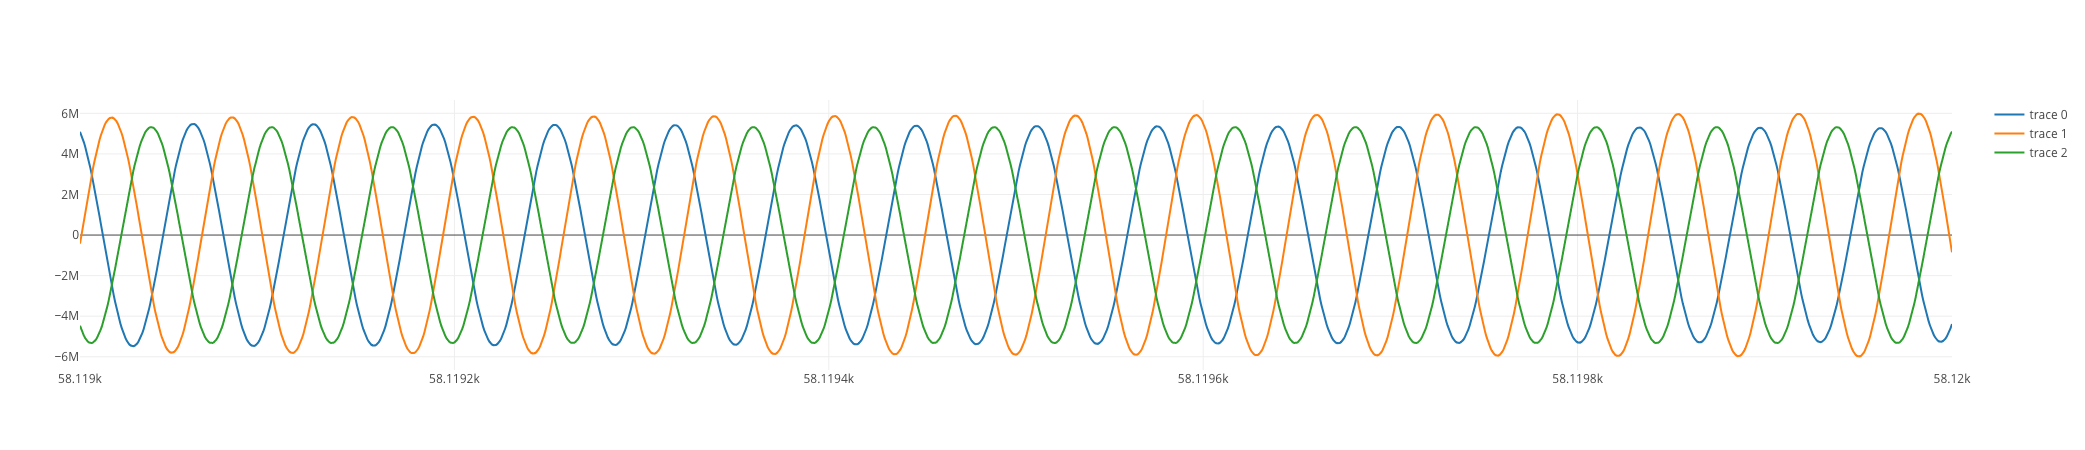

In [21]:
plot_data = [
    go.Scatter(
        x=orbit_df['$MJD^{UTC}$'],
        y=orbit_df['$x_{x}^{ECI}$']
    ),
    go.Scatter(
        x=orbit_df['$MJD^{UTC}$'],
        y=orbit_df['$x_{y}^{ECI}$']
    ),
    go.Scatter(
        x=orbit_df['$MJD^{UTC}$'],
        y=orbit_df['$x_{z}^{ECI}$']
    )
]

iplot(plot_data)